## Seinfeld NLP Analysis

From the <a href="https://www.kaggle.com/thec03u5/seinfeld-chronicles">Kaggle</a> dataset.

In [22]:
# imports

import matplotlib
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk import ngrams #for multi-word phrases
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from wordcloud import WordCloud as wc
from itertools import tee
import collections

In [23]:
# Load .csv's to dataframes, note these are expected to exist in your working directory

df_episodes = pd.read_csv("episode_info.csv")
df_scripts = pd.read_csv("scripts.csv")

In [24]:
# Let's take an inital look at each

df_episodes.head()

,Unnamed: 0,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,0,1.0,1.0,"Good News, Bad News","July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1,1.0,1.0,The Stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,2,1.0,2.0,The Robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,3,1.0,3.0,Male Unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,4,1.0,4.0,The Stock Tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04


In [25]:
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,2,GEORGE,Are you through?,1.0,S01E01,1.0
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0


Pretty standard stuff, a good dataset overall. We can throw out the "Unnamed: 0" column since it corresponds
to an index and pandas already gives us one.

In [26]:
df_episodes.drop("Unnamed: 0", axis=1, inplace=True)
df_scripts.drop("Unnamed: 0", axis=1, inplace=True)

In [27]:
# Check both datasets to make sure our changes were good

df_episodes.head()

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,"Good News, Bad News","July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,The Stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,The Robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,Male Unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,The Stock Tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04


In [65]:
df_scripts.head()

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,GEORGE,Are you through?,1.0,S01E01,1.0
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0


Data looks good (and pandas kept an index) so let's populate our stopwords - words we don't want to 
factor into a calculation. Note that you don't have to re-download the stopwords everytime, that line
can be commented out/removed for further runs

In [29]:
# download NLTK stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# add punctuation to the stopwords list

stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jputt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set our pyplot display parameters:
* Font size
* DPI on the image
* Bottom for the subplots of the figure 

In [30]:
plt.rcParams["font.size"]=10
plt.rcParams["savefig.dpi"]=100
plt.rcParams["figure.subplot.bottom"]=.1

With the initial 'house cleaning' done, we can define some functions that we can use to pull/examine data:
* Dialogue by Season - Pull the dialouge for a particular season and return a list of strings for nltk
* Most Common Word - calculate frequency of words in the text
* Plot Frequency - plot the frequency of the output of the Dialogue and Most Common functions

Note that these functions are 'Notebook-specific': they use variables we already created above and thus wouldn't work
if you extracted them straight.

In [38]:
def dialogue_by_season(s_num:int):
    """
    Retrieve dialogue from the episodes csv

    :param s_num: Season number to retrieve
    :type: int
    :return: list of strings of dialogue for the specified season: unordered, no stopwords and alpha chars only
    :rtype: list
    """
    df_snum = df_scripts.loc[df_scripts["Season"]==s_num]
    df_snum = df_snum["Dialogue"]
    
    dialogue_string = df_snum.str.cat(sep= ' ')
    
    dialogue_list = [i.lower() for i in wordpunct_tokenize(dialogue_string)
                    if i.lower() not in stop and i.isalpha()]

    return dialogue_list


def most_common(dialogue_string:str, word_num:int):
    """
    Calcuate the most common n words from the provided strings

    :param dialogue_string: string of words to analyze
    :type: string
    :return: the frequency of the top n words
    :rtype: nlkt.fd object
    """
    frequency_distribution = nltk.FreqDist(dialogue_string)
    common_words = frequency_distribution.most_common(word_num)

    return common_words


And also a function to plot that frequency

In [46]:
def plot_frequency(frequency_object):
    """
    Plot a frequency object

    :param frequency_object: a frequncy list from nltk
    :type: nltk.fd object
    """
    plt.barh(range(len(frequency_object)), 
            [val[1] for val in frequency_object], align='center')
    plt.yticks(range(len(frequency_object)), 
            [val[0] for val in frequency_object])
    plt.show()

Let's load and plot some data:

In [52]:
season_one_dialogue = dialogue_by_season(1)
season_two_dialoge = dialogue_by_season(2)
season_three_dialogue = dialogue_by_season(3)

mc_season_one = most_common(season_one_dialogue, 15)
mc_season_two = most_common(season_two_dialoge, 15)
mc_season_three = most_common(season_three_dialogue, 15)

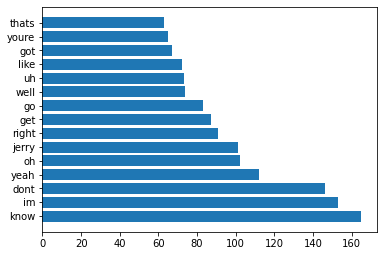

In [53]:
plot_frequency(mc_season_one)

The most common word in season one is "know" which may seem strange but I, as an NYC ex-pat can explain this deviation:
It's used commonly in the vernacular: "You don't know this", "You don't know what you're talking about", "What do you know" etc.
Arguably we could add some of these to stopwords to see if we can get a more detailed analysis

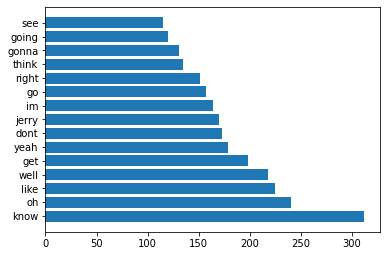

In [55]:
plot_frequency(mc_season_two)

Season 2 is much the same, again we might think about updating our stops

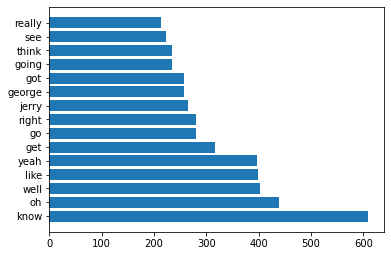

In [60]:
plot_frequency(mc_season_three)

As is season 3, overall we need to update stopwords and re-analyze

Let's make a word cloud with the top 200 words from the series and see if there's anything interesting 
in that.

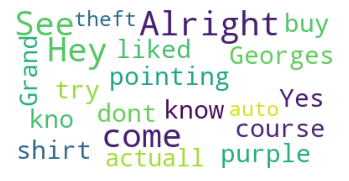

In [64]:
season_word_cloud = wc(
    background_color="white",
    stopwords=stop,
    max_words=200,
    max_font_size=40,
    random_state=42,
).generate(
    str(df_scripts["Dialogue"])
)


fig = plt.figure(1)
plt.imshow(season_word_cloud)
plt.axis("off")
plt.show()